In [1]:
import torch
# GPU varsa kullan, yoksa CPU kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)

Kullanılacak cihaz: cuda


In [2]:

 # --- Gerekli kütüphaneler ---
import torch
from torchvision import datasets, transforms
import torch
print("GPU kullanılabilir mi?", torch.cuda.is_available())
print("Kullanılan cihaz:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# --- Transform: Yeniden boyutlandırma + tensor + normalizasyon ---
transform = transforms.Compose([
 transforms.Resize((224,224)), # Tüm görüntüleri 224x224 boyutuna getir
 transforms.ToTensor(), # PyTorch tensor'ına çevir
 transforms.Normalize([0.485,0.456,0.406], # ImageNet normalizasyonu (mean)
 [0.229,0.224,0.225]) # ImageNet normalizasyonu (std)
])

# --- Dataset klasör yolu ---
DATA_DIR = r'C:\Users\Külkedisi\Desktop\DLP Batch\garbage-dataset'
# --- Dataset oluştur ---
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
print("Sınıflar:", dataset.classes)


GPU kullanılabilir mi? True
Kullanılan cihaz: NVIDIA GeForce RTX 4060 Laptop GPU
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


mkdir -p failed for path C:\Users\Külkedisi\.matplotlib: [WinError 5] Access is denied: 'C:\\Users\\Külkedisi\\.matplotlib'
Matplotlib created a temporary cache directory at C:\Users\KLKEDI~1\AppData\Local\Temp\matplotlib-rmwawc10 because there was an issue with the default path (C:\Users\Külkedisi\.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Kullanılacak cihaz: cuda
GPU Adı: NVIDIA GeForce RTX 4060 Laptop GPU
Toplam örnek sayısı: 19762
Sınıflar: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Eğitim örnek sayısı: 13833, Doğrulama: 2964, Test: 2965

--- Deneme LR: 0.000010 ---
Epoch 1/5 - Train Acc: 0.5657 - Val Acc: 0.6356
Epoch 2/5 - Train Acc: 0.7243 - Val Acc: 0.6862
Epoch 3/5 - Train Acc: 0.8343 - Val Acc: 0.6950
Epoch 4/5 - Train Acc: 0.9041 - Val Acc: 0.7173
Epoch 5/5 - Train Acc: 0.9351 - Val Acc: 0.7220

--- Deneme LR: 0.000056 ---
Epoch 1/5 - Train Acc: 0.7480 - Val Acc: 0.6970
Epoch 2/5 - Train Acc: 0.9132 - Val Acc: 0.7061
Epoch 3/5 - Train Acc: 0.9770 - Val Acc: 0.7348
Epoch 4/5 - Train Acc: 0.9920 - Val Acc: 0.7291
Epoch 5/5 - Train Acc: 0.9960 - Val Acc: 0.7399

--- Deneme LR: 0.000316 ---
Epoch 1/5 - Train Acc: 0.7532 - Val Acc: 0.6707
Epoch 2/5 - Train Acc: 0.9244 - Val Acc: 0.7007
Epoch 3/5 - Train Acc: 0.9797 - Val Acc: 0.7291
Epoch 4/5 - Train Acc

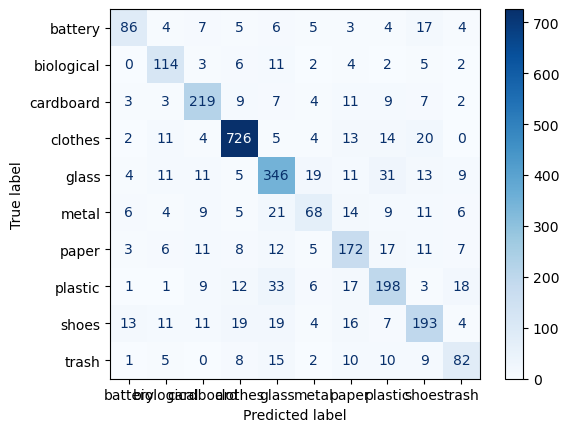

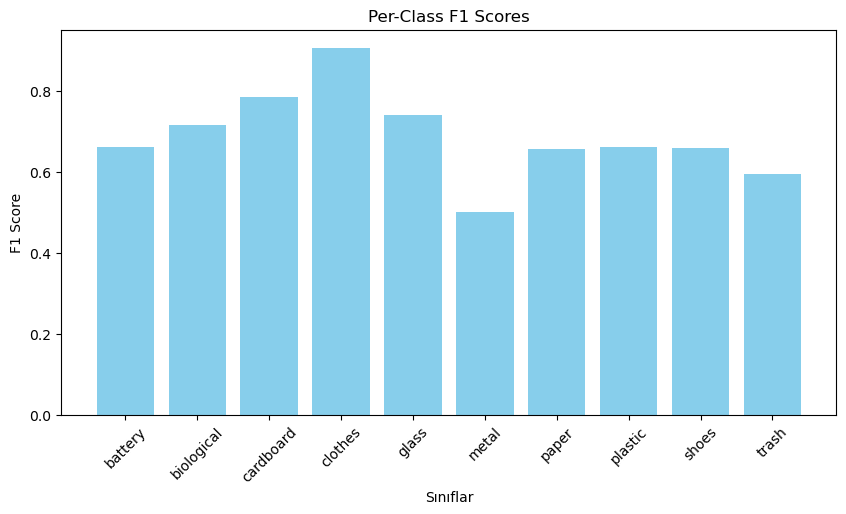

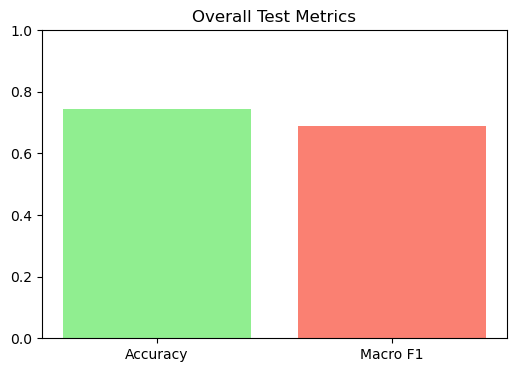

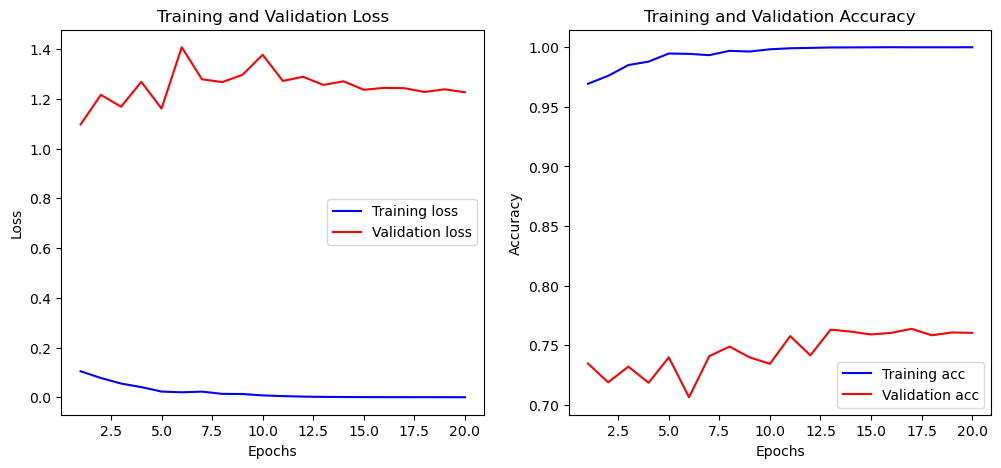

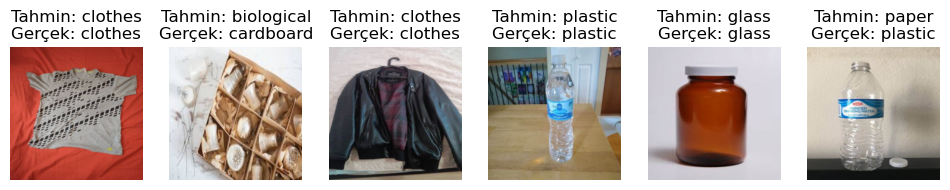

In [1]:
# -----------------------------
# 0️⃣ Gerekli Kütüphaneler
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# 1️⃣ Device ayarı
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılacak cihaz:", device)
if torch.cuda.is_available():
    print("GPU Adı:", torch.cuda.get_device_name(0))

# Matplotlib permission sorunu için
os.environ['MPLCONFIGDIR'] = r'C:\Users\Külkedisi\matplotlib_config'

# -----------------------------
# 2️⃣ Dataset ve Transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

DATA_DIR = r'C:\Users\Külkedisi\Desktop\DLP Batch\garbage-dataset'
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
print("Toplam örnek sayısı:", len(dataset))
print("Sınıflar:", dataset.classes)

# -----------------------------
# 3️⃣ Train/Val/Test Split
# -----------------------------
BATCH_SIZE = 32
targets = [s[1] for s in dataset.samples]

train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, stratify=targets, random_state=42)
temp_targets = [targets[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_targets, random_state=42)

train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim örnek sayısı: {len(train_idx)}, Doğrulama: {len(val_idx)}, Test: {len(test_idx)}")

# -----------------------------
# 4️⃣ CNN + BatchNorm Model
# -----------------------------
class CNNBatchNorm(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(dataset.classes)
model = CNNBatchNorm(num_classes).to(device)

# -----------------------------
# 5️⃣ Hiperparametre & Eğitim Fonksiyonları
# -----------------------------
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs,1)
        running_corrects += torch.sum(preds==labels).item()
        total += labels.size(0)
    return running_loss/total, running_corrects/total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds==labels).item()
            total += labels.size(0)
    return running_loss/total, running_corrects/total

# -----------------------------
# 6️⃣ Random LR Search
# -----------------------------
import copy

lr_candidates = np.logspace(-5,-2,5)
random_epochs = 5
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
criterion = nn.CrossEntropyLoss()

for lr in lr_candidates:
    print(f"\n--- Deneme LR: {lr:.6f} ---")
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=random_epochs)
    for epoch in range(random_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{random_epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")
        scheduler.step()
    # En iyi modeli kaydet
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# En iyi ağırlıkları yükle
model.load_state_dict(best_model_wts)
final_model = model

# -----------------------------
# 7️⃣ Final Eğitim (20 epoch)
# -----------------------------
final_epochs = 20
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=final_epochs)
history = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

for epoch in range(final_epochs):
    train_loss, train_acc = train_epoch(final_model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(final_model, val_loader, criterion)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Final Epoch {epoch+1}/{final_epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")
    scheduler.step()

# -----------------------------
# 8️⃣ Test & Görselleştirme
# -----------------------------
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=dataset.classes))
    return acc, macro_f1, per_class_f1, all_labels, all_preds

def plot_confusion_matrix(labels, preds, classes):
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=classes, cmap=plt.cm.Blues)
    plt.show()

def plot_f1_per_class(per_class_f1, classes):
    plt.figure(figsize=(10,5))
    plt.bar(classes, per_class_f1, color='skyblue')
    plt.xlabel("Sınıflar")
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Scores")
    plt.xticks(rotation=45)
    plt.show()

def plot_overall_metrics(acc, macro_f1):
    plt.figure(figsize=(6,4))
    plt.bar(["Accuracy", "Macro F1"], [acc, macro_f1], color=['lightgreen','salmon'])
    plt.ylim(0,1)
    plt.title("Overall Test Metrics")
    plt.show()

def plot_training_history(history):
    epochs = range(1,len(history['train_loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'],'b', label='Training loss')
    plt.plot(epochs, history['val_loss'],'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'],'b', label='Training acc')
    plt.plot(epochs, history['val_acc'],'r', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def show_random_test_images(model, dataloader, classes, n=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12,6))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            for i in range(images.size(0)):
                if images_shown >= n:
                    break
                img = images[i].cpu().permute(1,2,0).numpy()
                img = np.clip(img*[0.229,0.224,0.225]+[0.485,0.456,0.406],0,1)
                plt.subplot(1,n,images_shown+1)
                plt.imshow(img)
                plt.title(f"Tahmin: {classes[preds[i]]}\nGerçek: {classes[labels[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= n:
                break
    plt.show()

# -----------------------------
# 9️⃣ Test ve Görselleştirme Çağrıları
# -----------------------------
acc, macro_f1, per_class_f1, labels, preds = evaluate_model(final_model, test_loader)
print(f"Test Accuracy: {acc:.4f}, Test Macro F1: {macro_f1:.4f}")
plot_confusion_matrix(labels, preds, dataset.classes)
plot_f1_per_class(per_class_f1, dataset.classes)
plot_overall_metrics(acc, macro_f1)
plot_training_history(history)
show_random_test_images(final_model, test_loader, dataset.classes, n=6)
